# Bias model bootstrapping notebook

Eventually this notebook will (hopefully?) contain all the code necessary to run our final experiments.
For now it just contains a demo of MCE IRL on some gridworlds from the "learning biases" paper.

First we have some not-very-interesting setup:

In [2]:
%matplotlib inline

# These are useful for debugging, but make code slower:
%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax
import jax.experimental.optimizers as jopt
import jax.random as jrandom
import numpy as np

from pref_bootstrap.envs import gridworld, mdp_interface
from pref_bootstrap.algos import mce_irl
import pref_bootstrap.feedback_learner_blind_irl as fbl_blind_irl
import pref_bootstrap.feedback_learner_paired_comparisons as fbl_paired_comp
import pref_bootstrap.reward_models as r_models
import pref_bootstrap.expert_base as experts

sns.set(context='notebook', style='darkgrid')
logging.basicConfig(level=logging.INFO)
np.set_printoptions(precision=4, linewidth=100)

## Very simple example of using environments and MCE IRL code

This code doesn't use the new agent API

In [3]:
random_gridworld = gridworld.GridworldMdp.generate_random(4, 4, 0.2, 0.1)
env = mdp_interface.GridworldEnvWrapper(random_gridworld, random_gridworld.height + random_gridworld.width)

In [4]:
# generate some optimal demos (represented by a single optimal occupancy measure vector) and run MCE IRL
_, optimal_om = mce_irl.mce_occupancy_measures(env)
rmodel = r_models.LinearRewardModel(env.obs_dim)
opt_tup = jopt.momentum(1e-2, 0.9)

In [5]:
rew_params, visitations = mce_irl.mce_irl(env, opt_tup, rmodel, optimal_om, print_interval=100, max_iter=1000)

INFO:root:Occupancy measure error@iter   0: 4.988160 (||params||=3.971815, ||grad||=6.247153, ||E[dr/dw]||=4.734044)
INFO:root:Occupancy measure error@iter  100: 0.055015 (||params||=4.646745, ||grad||=0.064917, ||E[dr/dw]||=6.008991)
INFO:root:Occupancy measure error@iter  200: 0.014059 (||params||=4.450650, ||grad||=0.016256, ||E[dr/dw]||=5.965172)
INFO:root:Occupancy measure error@iter  300: 0.008065 (||params||=4.427583, ||grad||=0.009523, ||E[dr/dw]||=5.963070)
INFO:root:Occupancy measure error@iter  400: 0.004521 (||params||=4.419999, ||grad||=0.005375, ||E[dr/dw]||=5.962824)
INFO:root:Occupancy measure error@iter  500: 0.002476 (||params||=4.416963, ||grad||=0.002956, ||E[dr/dw]||=5.962768)
INFO:root:Occupancy measure error@iter  600: 0.001339 (||params||=4.415679, ||grad||=0.001603, ||E[dr/dw]||=5.962764)


In [6]:
print('Optimal state visitation frequencies for each grid cell:')
print(optimal_om.reshape((random_gridworld.height, random_gridworld.width)))
print('\nRecovered state visitation frequencies for each grid cell:')
print(visitations.reshape((random_gridworld.height, random_gridworld.width)))

Optimal state visitation frequencies for each grid cell:
[[0.     0.     0.     0.    ]
 [0.     5.8141 0.5664 0.    ]
 [0.     0.5664 1.053  0.    ]
 [0.     0.     0.     0.    ]]

Recovered state visitation frequencies for each grid cell:
[[0.     0.     0.     0.    ]
 [0.     5.8142 0.5669 0.    ]
 [0.     0.5669 1.052  0.    ]
 [0.     0.     0.     0.    ]]


## More complex example showing how to use an EnvFeedbackModel to recover both a reward function + sub-rationality model

This code actually does use the new API to show how to use the 'blind IRL' feedback model (& its associated expert, which doesn't support observation blinding yet).

In [7]:
irl_feedback_model = fbl_blind_irl.BlindIRLFeedbackModel(env)
rmodel = r_models.LinearRewardModel(env.obs_dim)
rng = jrandom.PRNGKey(42)
irl_bias_params, rng = irl_feedback_model.init_bias_params(rng)
irl_expert = experts.MEDemonstratorExpert(env, np.random.randint((1 << 31) - 1))
# we'll do IRL based on 10 trajectories
irl_dataset = irl_expert.interact(10)

In [8]:
print('Log likelihood (IRL):', float(irl_feedback_model.log_likelihood(irl_dataset, rmodel, irl_bias_params)))
print('Gradient w.r.t. reward params (IRL):\n', np.asarray(irl_feedback_model.log_likelihood_grad_rew(irl_dataset, rmodel, irl_bias_params)))
print('Gradient w.r.t. bias params (IRL):\n', irl_feedback_model.log_likelihood_grad_bias(irl_dataset, rmodel, irl_bias_params))

Log likelihood (IRL): -9.270973205566406
Gradient w.r.t. reward params (IRL):
 [ 0.      0.      0.      0.      0.      0.0516 -0.0122  0.      0.     -0.0117 -0.0079  0.
  0.      0.      0.      0.    ]
Gradient w.r.t. bias params (IRL):
 [0.     0.     0.     0.     0.     0.1282 0.0195 0.     0.     0.0322 0.0508 0.     0.     0.
 0.     0.    ]


## Another example with the paired comparison learner

In [9]:
pc_feedback_model = fbl_paired_comp.PairedCompFeedbackModel(env)
pc_bias_params, rng = pc_feedback_model.init_bias_params(rng)
pc_expert = experts.PairedComparisonExpert(env, boltz_temp=1.0, seed=42)

# generate some random trajectories & compare a random subset of them
def generate_comparison_dataset(pc_ntraj):
    pc_trajectories = mce_irl.mce_irl_sample(env, pc_ntraj, R=np.ones((env.n_states, )))
    to_compare_first = np.arange(len(pc_trajectories['states']))
    comparisons = []
    for first_idx in range(pc_ntraj):
        second_idx = np.random.randint(pc_ntraj - 1)
        if second_idx >= first_idx:
            second_idx += 1
        traj1_is_better = pc_expert.interact(
            dict(states=pc_trajectories['states'][first_idx]),
            dict(states=pc_trajectories['states'][second_idx]))
        if traj1_is_better:
            # the better trajectory comes before the worse one
            comparisons.append((first_idx, second_idx))
        else:
            comparisons.append((second_idx, first_idx))
    return {
        'trajectories': pc_trajectories,
        'comparisons': np.asarray(comparisons),
    }

comparison_dataset = generate_comparison_dataset(10)

In [10]:
print('Log likelihood (PC):', float(pc_feedback_model.log_likelihood(comparison_dataset, rmodel, pc_bias_params)))
print('Gradient w.r.t. reward params (PC):\n', np.asarray(pc_feedback_model.log_likelihood_grad_rew(comparison_dataset, rmodel, pc_bias_params)))
print('Gradient w.r.t. bias params (PC):\n', pc_feedback_model.log_likelihood_grad_bias(comparison_dataset, rmodel, pc_bias_params))

Log likelihood (PC): -0.5336802005767822
Gradient w.r.t. reward params (PC):
 [ 0.      0.      0.      0.      0.      0.0324 -0.3352  0.      0.      0.1944  0.1084  0.
  0.      0.      0.      0.    ]
Gradient w.r.t. bias params (PC):
 0.012834102


In [11]:
# ALRIGHT, HERE IS WHERE I WILL DEBUG THE TOPK FEEDBACK LEARNER
# ABLATIONS: COULD WE DO BETTER IF ALL OUR TRAJECTORIES ARE GOOD? 
# OR IS IT NECESSARY TO HAVE BAD TRAJECTORIES? 

In [12]:
import pref_bootstrap.feedback_learner_topk as fbl_topk

rmodel = r_models.LinearRewardModel(env.obs_dim)
top_K_feedback_model = fbl_topk.TopKFeedbackModel(env)
top_K_expert = experts.TopKExpert(env, temp=.3, K=.05, seed=42)

In [13]:
# def genereate_top_K_dataset(n_traj): 
import random

n_traj = 1000
traj = mce_irl.mce_irl_sample(env, n_traj, R=np.ones((env.n_states,)))
labels= top_K_expert.interact(traj)

labels_final, traj_final = [], []
for l, t in zip(labels, traj['states']): 
    if not(l):
        if True:#random.random() < (np.sum(labels)/len(labels)):
            labels_final.append(l), traj_final.append(t)
    else: 
        labels_final.append(l), traj_final.append(t)
        
labels_final = np.array(labels_final)
        
print(np.sum(labels)/len(labels))
print(np.sum(labels_final)/len(labels_final))


cutoff 15.0
0.093
0.093


In [16]:
params = {}
from jax import random as jrnd
import jax.numpy as jnp
from jax import grad, value_and_grad
key = jrnd.PRNGKey(0)
key, wkey = jrnd.split(key, 2)
params['reward_est'] = jrnd.normal(wkey, (env.n_states,))
params['bias'] = jnp.ones((1,))
params['temp'] = jnp.ones((1,))
# params['temperature'] = .5*jnp.ones((1, ))
lr = 1e-3
steps = 10000
loss_prev = float('Inf')
delta = 100
eps = 1e-5

step = 0
while(np.abs(delta) > eps and step<steps):
    loss, gradients = (value_and_grad(top_K_feedback_model.loss)(params, np.array(traj_final), (labels_final)))
    if step % 100 == 0:
        print('step %d loss %.3f' %(step, loss))
        print(params['bias'])
    if step > 0: 
        delta = loss-loss_prev
   
    for k in params.keys(): 
        params[k] -= lr*gradients[k]
        
    loss_prev = loss
    step +=1
    
if np.abs(delta) <= .0001: 
    print('terminated due to delta')
else: 
    print('terminated due to steps exceeding %d' %steps)


step 0 loss 0.411
[1.]
step 100 loss 0.384
[1.0019]
step 200 loss 0.364
[1.0027]
step 300 loss 0.349
[1.0027]
step 400 loss 0.336
[1.0022]
step 500 loss 0.326
[1.0014]
step 600 loss 0.317
[1.0004]
step 700 loss 0.309
[0.9992]
step 800 loss 0.302
[0.9979]
step 900 loss 0.296
[0.9967]
step 1000 loss 0.290
[0.9954]
step 1100 loss 0.285
[0.9941]
step 1200 loss 0.281
[0.9928]
step 1300 loss 0.277
[0.9916]
step 1400 loss 0.273
[0.9904]
step 1500 loss 0.270
[0.9893]
step 1600 loss 0.267
[0.9882]
step 1700 loss 0.265
[0.9872]
step 1800 loss 0.262
[0.9862]
step 1900 loss 0.260
[0.9852]
step 2000 loss 0.258
[0.9843]
step 2100 loss 0.256
[0.9834]
step 2200 loss 0.254
[0.9826]
step 2300 loss 0.252
[0.9818]
step 2400 loss 0.251
[0.981]
step 2500 loss 0.250
[0.9803]
step 2600 loss 0.248
[0.9796]
step 2700 loss 0.247
[0.9789]
step 2800 loss 0.246
[0.9783]
terminated due to delta


In [22]:
np.array(params['reward_est'])

print(params['temp']) 

[0.8586]


Text(0.5,1,'Estimated Reward Function')

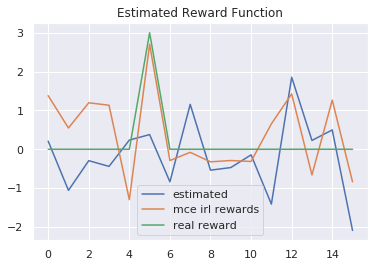

In [18]:
plt.plot(params['reward_est'], label='estimated')
plt.plot(rew_params, label='mce irl rewards')
plt.plot(env.reward_matrix, label='real reward')
plt.legend()
plt.title('Estimated Reward Function')

In [32]:
_, topk_om = mce_irl.mce_occupancy_measures(env, R=params['reward_est']/jnp.std(params['reward_est']))

In [33]:
print('Optimal state visitation frequencies for each grid cell:')
print(optimal_om.reshape((random_gridworld.height, random_gridworld.width)))

Optimal state visitation frequencies for each grid cell:
[[0.     0.     0.     0.    ]
 [0.     5.8141 0.5664 0.    ]
 [0.     0.5664 1.053  0.    ]
 [0.     0.     0.     0.    ]]


In [34]:
print('Inferred w. Top K')
print(topk_om.reshape((random_gridworld.height, random_gridworld.width)))

Inferred w. Top K
[[0.     0.     0.     0.    ]
 [0.     3.21   0.6811 0.    ]
 [0.     1.3795 2.7293 0.    ]
 [0.     0.     0.     0.    ]]


In [1]:
print('Optimal state visitation frequencies for each grid cell:')
print(env.reward_matrix.reshape((random_gridworld.height, random_gridworld.width)))

Optimal state visitation frequencies for each grid cell:


NameError: name 'env' is not defined

cutoff 12.0
0.081
0.081
step 0 loss 0.769
[1.]
step 100 loss 0.391
[1.0201]
step 200 loss 0.322
[1.0267]
step 300 loss 0.299
[1.0288]
step 400 loss 0.287
[1.0289]
step 500 loss 0.279
[1.028]
step 600 loss 0.273
[1.0265]
step 700 loss 0.268
[1.0247]
step 800 loss 0.264
[1.0225]
step 900 loss 0.260
[1.0203]
step 1000 loss 0.256
[1.018]
step 1100 loss 0.252
[1.0156]
step 1200 loss 0.249
[1.0132]
step 1300 loss 0.245
[1.0108]
step 1400 loss 0.242
[1.0085]
step 1500 loss 0.239
[1.0062]
step 1600 loss 0.237
[1.0039]
step 1700 loss 0.234
[1.0017]
step 1800 loss 0.232
[0.9996]
step 1900 loss 0.229
[0.9975]
step 2000 loss 0.227
[0.9955]
step 2100 loss 0.225
[0.9935]
step 2200 loss 0.223
[0.9916]
step 2300 loss 0.222
[0.9898]
step 2400 loss 0.220
[0.9881]
step 2500 loss 0.219
[0.9864]
step 2600 loss 0.217
[0.9847]
step 2700 loss 0.216
[0.9831]
step 2800 loss 0.215
[0.9816]
step 2900 loss 0.214
[0.9801]
step 3000 loss 0.212
[0.9787]
terminated due to delta
Inferred w. Top K
[[0.     0.     0.    

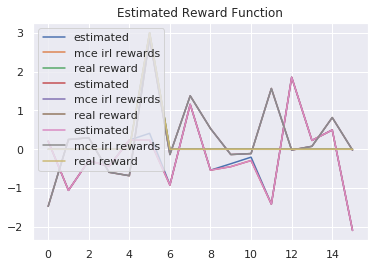

In [20]:
# Doing the reward and then the other thing
params = {}
from jax import random as jrnd
import jax.numpy as jnp
from jax import grad, value_and_grad
key = jrnd.PRNGKey(0)
key, wkey = jrnd.split(key, 2)
params['reward_est'] = jrnd.normal(wkey, (env.n_states,))
params['bias'] = jnp.ones((1,))


for iter in range(3):

    # def genereate_top_K_dataset(n_traj): 
    import random

    n_traj = 1000
    traj = mce_irl.mce_irl_sample(env, n_traj, R=params['reward_est'])
    labels= top_K_expert.interact(traj)

    labels_final, traj_final = [], []
    for l, t in zip(labels, traj['states']): 
        if not(l):
            if True:#random.random() < (np.sum(labels)/len(labels)):
                labels_final.append(l), traj_final.append(t)
        else: 
            labels_final.append(l), traj_final.append(t)

    labels_final = np.array(labels_final)



    # params['temperature'] = .5*jnp.ones((1, ))
    lr = 1e-3
    steps = 10000
    loss_prev = float('Inf')
    delta = 100
    eps = 1e-5

    step = 0
    while(np.abs(delta) > eps and step<steps):
        loss, gradients = (value_and_grad(top_K_feedback_model.loss)(params, np.array(traj_final), (labels_final)))
        if step % 100 == 0:
            print('step %d loss %.3f' %(step, loss))
            print(params['bias'])
        if step > 0: 
            delta = loss-loss_prev

        for k in params.keys(): 
            params[k] -= lr*gradients[k]

        loss_prev = loss
        step +=1

    if np.abs(delta) <= .0001: 
        print('terminated due to delta')
    else: 
        print('terminated due to steps exceeding %d' %steps)
        
        
    plt.plot(params['reward_est'], label='estimated')
    plt.plot(rew_params, label='mce irl rewards')
    plt.plot(env.reward_matrix, label='real reward')
    plt.legend()
    plt.title('Estimated Reward Function')
    
    print('Inferred w. Top K')
    print(topk_om.reshape((random_gridworld.height, random_gridworld.width)))

    print('Optimal state visitation frequencies for each grid cell:')
    print(optimal_om.reshape((random_gridworld.height, random_gridworld.width)))